# Predicción de producción usando Prophet

In [1]:
import math
import itertools
from datetime import datetime
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_forecast_component
from prophet.serialize import model_to_json, model_from_json
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
import logging
import json
from sklearn.preprocessing import MinMaxScaler
from enum import Enum
pd.set_option('display.max_columns', None)

In [2]:
IN_COLAB = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False

In [3]:
if IN_COLAB:
  !pip install --quiet optuna
import optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.4 MB/s eta 0:00:00


In [4]:
# Se deshabilitan unos logs molestos
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

In [5]:
class PredictionMode(str, Enum):
  single = 'single'
  single_with_aggregate = 'single_with_aggregate'
  single_with_area_aggregate = 'single_with_area_aggregate'

In [6]:
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  CODE_PATH = '/content/drive/MyDrive/Trabajo profesional/Code/' # absolute path
else:
  CODE_PATH = '' # relative path

Mounted at /content/drive


In [7]:
dataset = pd.read_csv(CODE_PATH + "data/prod_split_train_2024-05-28_15:05:17.csv", index_col=0, low_memory=False)
dataset["fecha"] = pd.to_datetime(dataset["fecha"])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134850 entries, 0 to 134849
Data columns (total 35 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   idempresa                134850 non-null  object        
 1   fecha                    134850 non-null  datetime64[ns]
 2   periodo                  134850 non-null  int64         
 3   anio                     134850 non-null  int64         
 4   mes                      134850 non-null  int64         
 5   prod                     134850 non-null  float64       
 6   idpozo                   134850 non-null  int64         
 7   tipopozo                 134850 non-null  object        
 8   prod_pet                 134850 non-null  float64       
 9   prod_gas                 134850 non-null  float64       
 10  prod_agua                134850 non-null  float64       
 11  tef                      134850 non-null  float64       
 12  tipoextraccion       

In [8]:
wells_ids_to_predict = [158364, 160211, 160332, 160789, 160810, 160814, 161451, 162200, 162405, 162955, 163237, 163942]

MONTHS_TO_PREDICT = 3
NUMBER_OF_TRIALS_OPTUNA = 100
OPTUNA_TIMEOUT = 1800 # seconds
PREDICTION_MODE = PredictionMode.single_with_area_aggregate

DEFAULT_FIXED_PARAMS = {
    'yearly_seasonality': 'auto',
    'mean_prod_pet_prior_scale': 10
}

## Producción promedio total
Se obtiene la curva de producción promedio (según el período en el que se empezó a producir), se la normaliza y se la deja lista para posteriormente usarla como "Additional regressors" en Prophet.

,mean_prod_pet
periodo,
0,0.781526
1,0.998660
2,1.000000
3,0.925370
4,0.829036
...,...
114,0.014340
115,0.013025
116,0.021138


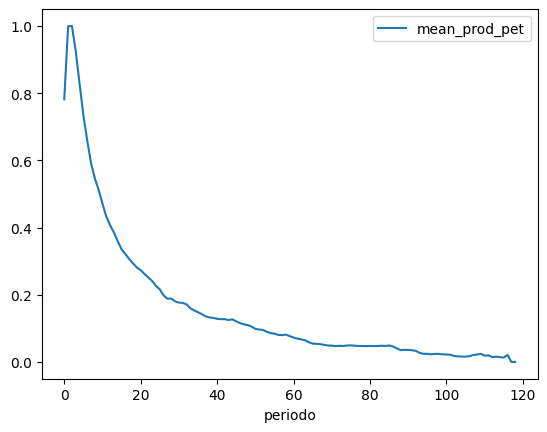

In [9]:
wells_aggregate_curve = dataset.groupby(by="periodo")[["prod_pet"]].mean()
scaler = MinMaxScaler()
wells_aggregate_curve['prod_pet'] = scaler.fit_transform(wells_aggregate_curve[['prod_pet']])
wells_aggregate_curve = wells_aggregate_curve.rename(columns={"prod_pet": "mean_prod_pet"})
wells_aggregate_curve.plot()
wells_aggregate_curve

## Producción promedio por área de yacimiento
Se obtiene la curva de producción promedio según el área de yacimiento, se la normaliza y se la deja lista para posteriormente usarla como "Additional regressors" en Prophet.

Como había algunas áreas con pocos pozos, pasaba que la curva promedio quedaba con menos períodos que los necesarios para realizar las estimaciones. Por eso en esos casos se tuvo que predecir la curva promedio usando Prophet.

In [10]:
def predict_wells_area_aggregate_curve(curve, number_of_periods_needed):
  df = curve.copy()
  df = df.merge(wells_aggregate_curve, how='left', on='periodo') # se le agrega la produccion promedio para ese periodo
  df = df.rename(columns={"prod_pet": "y"})
  df['ds'] = pd.date_range(start='2000-01-01', periods=len(df), freq='MS')
  model = Prophet(weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=False)
  model.add_regressor('mean_prod_pet', standardize=False, prior_scale=10, mode='additive')
  model.fit(df)

  number_of_periods_to_predict = number_of_periods_needed - len(curve)

  future = model.make_future_dataframe(periods=number_of_periods_to_predict, freq="MS") # MS to use monthly frequency
  future = future.merge(wells_aggregate_curve, how='left', left_index=True, right_on='periodo') # se le agrega la produccion promedio para ese periodo
  forecast = model.predict(future)
  # Replace negative numbers by zero
  forecast['yhat'].clip(lower=0, inplace=True)
  forecast['yhat_lower'].clip(lower=0, inplace=True)
  forecast['yhat_upper'].clip(lower=0, inplace=True)
  forecast = forecast.rename(columns={"yhat": "prod_pet"})[['prod_pet']]
  forecast.index = forecast.index.rename('periodo')
  return forecast # The entire curve is replaced

  #df_return = pd.concat([curve, forecast[-number_of_periods_to_predict:]])
  #print(df_return)
  #return df_return


Area: LOMA CAMPANA-LLL, Periodos del area: 115, Periodos mínimos necesarios: 79


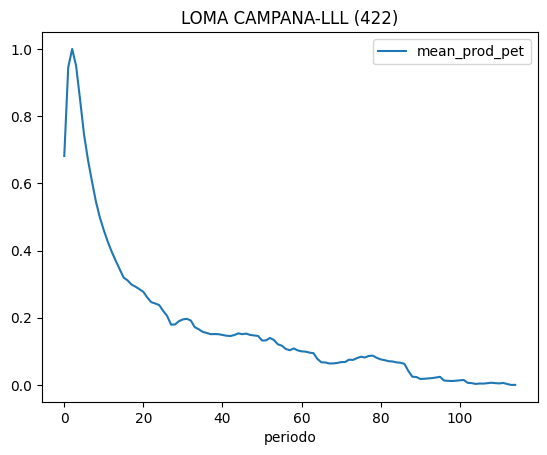

Area: MEDANO DE LA MORA, Periodos del area: 57, Periodos mínimos necesarios: 60
Se estima la curva promedio del area con Prophet


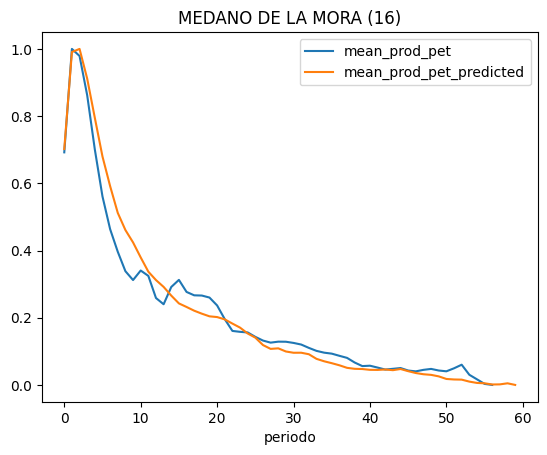

Area: SIERRA BARROSA, Periodos del area: 56, Periodos mínimos necesarios: 59
Se estima la curva promedio del area con Prophet


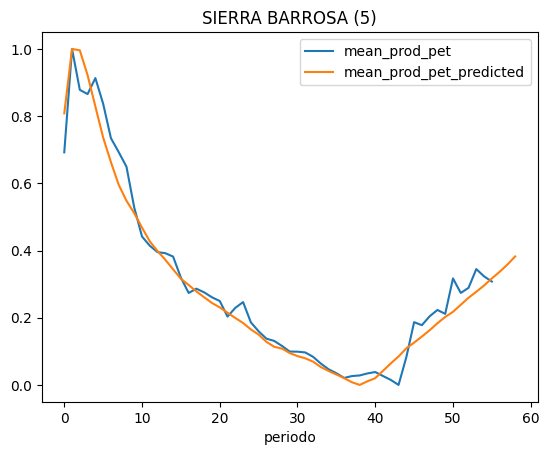

Area: LINDERO ATRAVESADO OCCIDENTAL, Periodos del area: 115, Periodos mínimos necesarios: 55


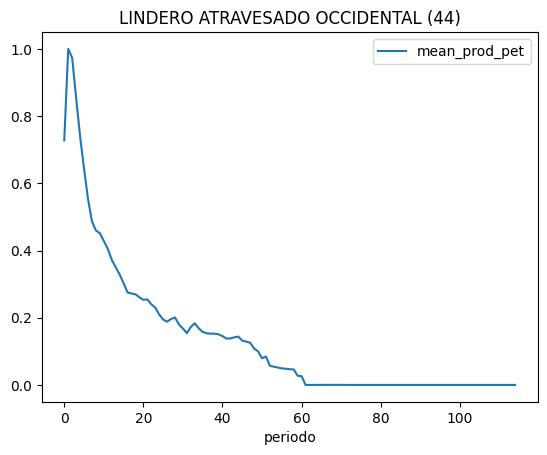

Area: LA CALERA, Periodos del area: 58, Periodos mínimos necesarios: 55


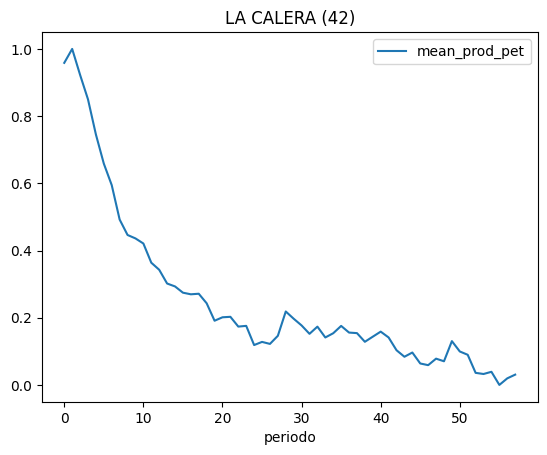

Area: COIRON AMARGO SUR ESTE, Periodos del area: 78, Periodos mínimos necesarios: 51


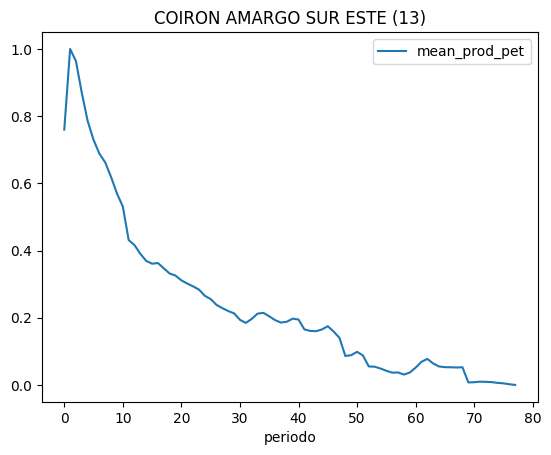

Area: BANDURRIA SUR, Periodos del area: 71, Periodos mínimos necesarios: 35


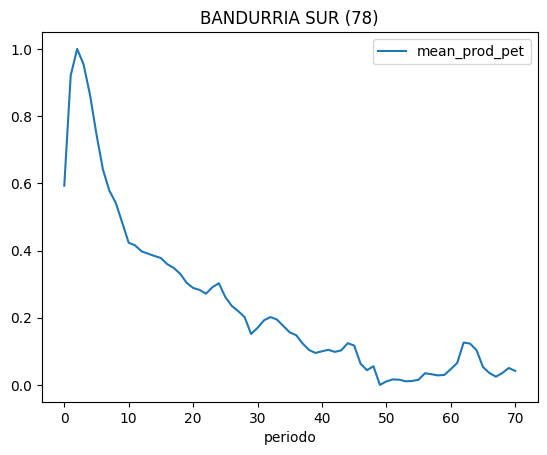

Area: LA AMARGA CHICA, Periodos del area: 94, Periodos mínimos necesarios: 33


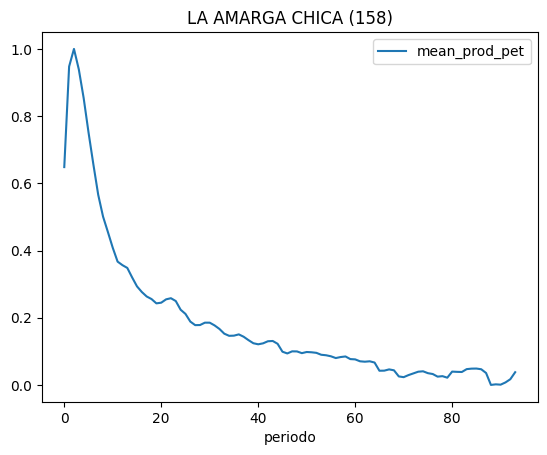

INFO:prophet:n_changepoints greater than number of observations. Using 15.


Area: BAJADA DEL PALO ESTE, Periodos del area: 21, Periodos mínimos necesarios: 24
Se estima la curva promedio del area con Prophet


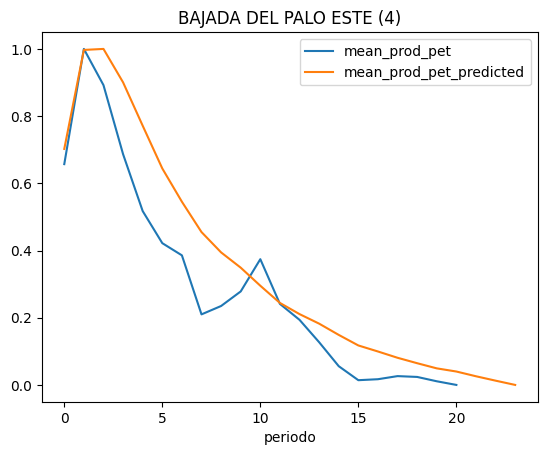

Area: LOMA CAMPANA, Periodos del area: 117, Periodos mínimos necesarios: 21


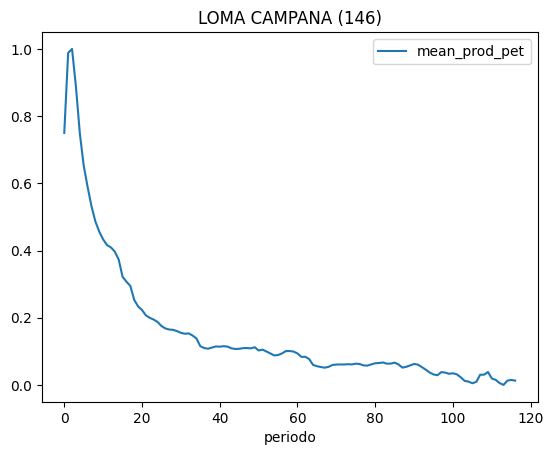

In [11]:
if PREDICTION_MODE == PredictionMode.single_with_area_aggregate:
  wells_area_aggregate_curves = {}

  areas_and_number_of_periods_needed = {}

  # Only the areas of the wells to be predicted are obtained
  for well_id in wells_ids_to_predict:
    well_data = dataset[dataset["idpozo"] == well_id].copy()
    area_yacimiento = well_data.iloc[0]['areayacimiento']
    if area_yacimiento not in areas_and_number_of_periods_needed:
      areas_and_number_of_periods_needed[area_yacimiento] = len(well_data) + MONTHS_TO_PREDICT
    else:
      areas_and_number_of_periods_needed[area_yacimiento] = max(areas_and_number_of_periods_needed[area_yacimiento], len(well_data) + MONTHS_TO_PREDICT)

  for area, number_of_periods_needed in areas_and_number_of_periods_needed.items():
    wells_area_prod = dataset[dataset["areayacimiento"] == area]
    wells_area_unique_count = len(wells_area_prod["idpozo"].value_counts())
    curve = wells_area_prod.groupby(by="periodo")[["prod_pet"]].mean()
    number_of_periods_in_the_area = len(curve)
    print(f"Area: {area}, Periodos del area: {number_of_periods_in_the_area}, Periodos mínimos necesarios: {number_of_periods_needed}")
    new_curve = None
    if number_of_periods_in_the_area < number_of_periods_needed:
      print("Se estima la curva promedio del area con Prophet")
      new_curve= predict_wells_area_aggregate_curve(curve, number_of_periods_needed)
      scaler = MinMaxScaler()
      new_curve['prod_pet'] = scaler.fit_transform(new_curve[['prod_pet']])
      new_curve = new_curve.rename(columns={"prod_pet": "mean_prod_pet"})
    scaler = MinMaxScaler()
    curve['prod_pet'] = scaler.fit_transform(curve[['prod_pet']])
    curve = curve.rename(columns={"prod_pet": "mean_prod_pet"})
    fig, ax = plt.subplots()
    ax = curve.plot(ax=ax, title=f"{area} ({wells_area_unique_count})", y="mean_prod_pet", label="mean_prod_pet")
    wells_area_aggregate_curves[area] = curve
    if new_curve is not None:
      ax = new_curve.plot(ax=ax, title=f"{area} ({wells_area_unique_count})", y="mean_prod_pet", label="mean_prod_pet_predicted")
      wells_area_aggregate_curves[area] = new_curve
    plt.show()

## Cuarentena de COVID 19
Vimos que en algunos pozos hay una caída abrupta (en algunos casos a cero) en los períodos correspondientes a la cuarentena de COVID.

Puede no solo tener que ver con el aislamiento en si, sino que hubo una caída muy fuerte en los precios y en la demanda de petróleo a nivel mundial durante esos períodos, por lo que aunque no haya parado la producción debido al aislamiento, si la demanda era baja, quizás se vieron obligados a parar la producción. (https://www.clarin.com/economia/pandemia-apagan-motores-vaca-muerta_0_NIgYdD9N4.html)

Para modelarlo como algo excepcional y que no afecte la tendencia global, lo trato como holidays.

In [12]:
# el aislamiento obligatorio en general en Argentina fue entre el 20 de marzo y el 26 de abril de 2020,
# pero para que sea mas flexible y abarque mayor cantidad de anomalias, lo seteo del 1/3 al 1/5 (60 dias)
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-01', 'lower_window': 0, 'upper_window': 60},
])
lockdowns['ds'] = pd.to_datetime(lockdowns['ds'])
lockdowns

,holiday,ds,lower_window,upper_window
0,lockdown_1,2020-03-01,0,60


In [13]:
def split_df_into_train_val(well_id, df):
  print(f"Pozo ID {well_id} - Partiendo el dataset en train y validation")
  val_size = max(math.ceil(df.shape[0] / 10), 2) # min 2
  train_df = df.iloc[:-val_size, :]
  val_df = df.iloc[-val_size:, :]
  print(f"Pozo ID {well_id} - El pozo tiene: {len(df)} registros totales, {len(train_df)} se usan para entrenar y {len(val_df)} se usan para validar")
  return train_df, val_df

In [14]:
def find_params(trial, train_df, val_df, holidays):
  parameters = {
      'changepoint_prior_scale': trial.suggest_float('changepoint_prior_scale', 0.001, 0.5),
      'changepoint_range': trial.suggest_float('changepoint_range', 0.8, 0.95),
      'seasonality_mode': trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative']),
      'seasonality_prior_scale': trial.suggest_float('seasonality_prior_scale', 0.01, 0.1),
      'holidays_prior_scale': trial.suggest_float('holidays_prior_scale', 0.01, 10),
      'yearly_seasonality': DEFAULT_FIXED_PARAMS['yearly_seasonality']}

  mean_prod_pet_params = {
      'prior_scale': DEFAULT_FIXED_PARAMS['mean_prod_pet_prior_scale'],
      'mode': trial.suggest_categorical('mean_prod_pet_mode', ['additive', 'multiplicative'])}

  m = Prophet(**parameters, holidays=holidays, weekly_seasonality=False, daily_seasonality=False)
  m.add_country_holidays(country_name='AR')
  if PREDICTION_MODE == PredictionMode.single_with_aggregate or PREDICTION_MODE == PredictionMode.single_with_area_aggregate:
    m.add_regressor('mean_prod_pet', standardize=False, **mean_prod_pet_params)
  m.fit(train_df)
  validation = m.predict(val_df)
  rmse_for_optuna = np.sqrt(mean_squared_error(val_df['y'], validation['yhat']))
  return rmse_for_optuna

In [15]:
def get_best_params_with_optuna(well_id, well_data, holidays=None):
  print(f"Pozo ID {well_id} - Tuneando hiperparámetros con Optuna")
  train_df, val_df = split_df_into_train_val(well_id, well_data)
  study = optuna.create_study(direction='minimize')
  study.optimize(lambda trial: find_params(trial, train_df, val_df, holidays), n_trials=NUMBER_OF_TRIALS_OPTUNA, n_jobs=-1, timeout=OPTUNA_TIMEOUT)
  best_params = study.best_params
  return {**best_params, **DEFAULT_FIXED_PARAMS}


In [16]:
def save_best_params(well_id, best_params):
  filename = CODE_PATH + 'data/models/prophet/prophet_best_params_' + PREDICTION_MODE + '_' + str(well_id) + '.json'
  print(f"Pozo ID {well_id} - Guardando best params en el archivo {filename}")
  with open(filename, 'w') as file:
    json.dump(best_params, file)

In [17]:
def get_best_params(well_id, well_data, holidays=None):
  try:
    # Load best params if exists
    filename = CODE_PATH + 'data/models/prophet/prophet_best_params_' + PREDICTION_MODE + '_' + str(well_id) + '.json'
    with open(filename, 'r') as file:
      print(f"Pozo ID {well_id} - Cargando best params desde el archivo {filename}")
      best_params = json.load(file)
  except IOError:
    best_params = get_best_params_with_optuna(well_id, well_data, holidays=holidays)
    save_best_params(well_id, best_params)
  return best_params

In [18]:
def create_model(well_id, well_data, holidays=None):
  best_params = get_best_params(well_id, well_data, holidays=holidays)

  mean_prod_pet_best_params = {}
  if 'mean_prod_pet_prior_scale' in best_params:
    mean_prod_pet_best_params['prior_scale'] = best_params.pop('mean_prod_pet_prior_scale')
  if 'mean_prod_pet_mode' in best_params:
    mean_prod_pet_best_params['mode'] = best_params.pop('mean_prod_pet_mode')

  print(f"Pozo ID {well_id} - Creando el modelo")
  model = Prophet(**best_params, holidays=holidays, weekly_seasonality=False, daily_seasonality=False)
  model.add_country_holidays(country_name='AR')
  if PREDICTION_MODE == PredictionMode.single_with_aggregate or PREDICTION_MODE == PredictionMode.single_with_area_aggregate:
    model.add_regressor('mean_prod_pet', standardize=False, **mean_prod_pet_best_params)
  return model

In [19]:
def get_well_area(well_id):
  return dataset[dataset["idpozo"] == well_id].iloc[0]['areayacimiento']

In [20]:
def predict(well_id, model):
  future = model.make_future_dataframe(periods=MONTHS_TO_PREDICT, freq="MS") # MS to use monthly frequency
  if PREDICTION_MODE == PredictionMode.single_with_aggregate:
    future = future.merge(wells_aggregate_curve, how='left', left_index=True, right_on='periodo') # se le agrega la produccion promedio para ese periodo
  elif PREDICTION_MODE == PredictionMode.single_with_area_aggregate:
    area_yacimiento = get_well_area(well_id)
    future = future.merge(wells_area_aggregate_curves[area_yacimiento], how='left', left_index=True, right_on='periodo') # se le agrega la produccion promedio para ese periodo del area de yacimiento
  forecast = model.predict(future)
  # Replace negative numbers by zero
  forecast['yhat'].clip(lower=0, inplace=True)
  forecast['yhat_lower'].clip(lower=0, inplace=True)
  forecast['yhat_upper'].clip(lower=0, inplace=True)
  return forecast

In [21]:
def get_well_data(well_id):
  """
  Returns well production data in the format required by Prophet.
  """
  well_data = dataset[dataset["idpozo"] == well_id].copy()
  well_data.sort_values(by=["fecha"], inplace=True)
  columns_to_return = ["ds", "y"]
  if PREDICTION_MODE == PredictionMode.single_with_aggregate:
    well_data = well_data.merge(wells_aggregate_curve, how='left', on='periodo') # se le agrega la produccion promedio para ese periodo
    columns_to_return.append("mean_prod_pet")
  elif PREDICTION_MODE == PredictionMode.single_with_area_aggregate:
    area_yacimiento = get_well_area(well_id)
    well_data = well_data.merge(wells_area_aggregate_curves[area_yacimiento], how='left', on='periodo') # se le agrega la produccion promedio para ese periodo del area de yacimiento
    columns_to_return.append("mean_prod_pet")
  well_data = well_data.rename(columns={"fecha": "ds", "prod_pet": "y"})[columns_to_return]
  return well_data

In [22]:
predictions = pd.DataFrame(columns=['fecha', 'idpozo', 'prod_pet'])

plt.ioff() # Disable interactive mode in matplotlib

for well_id in wells_ids_to_predict:
  well_data = get_well_data(well_id)

  model = create_model(well_id, well_data, holidays=lockdowns)

  print(f"Pozo ID {well_id} - Entrenando el modelo")
  model.fit(well_data)

  print(f"Pozo ID {well_id} - Realizando predicciones")
  forecast = predict(well_id, model)

  print(f"Pozo ID {well_id} - Guardando gráficos")

  fig = model.plot(forecast)
  plt.savefig(CODE_PATH + 'data/models/prophet/prophet_prediction_' + PREDICTION_MODE + '_' + str(well_id) + '.png')
  fig2 = model.plot_components(forecast)
  plt.savefig(CODE_PATH + 'data/models/prophet/prophet_prediction_components_' + PREDICTION_MODE + '_' + str(well_id) + '.png')

  forecast = forecast[['ds', 'yhat']]
  forecast = forecast.rename(columns={"ds": "fecha", "yhat": "prod_pet"})
  forecast['idpozo'] = well_id
  forecast = forecast.iloc[-MONTHS_TO_PREDICT:]
  predictions = pd.concat([predictions, forecast], ignore_index=True)

plt.ion() # Enable interactive mode in matplotlib

Pozo ID 158364 - Cargando best params desde el archivo /content/drive/MyDrive/Trabajo profesional/Code/data/models/prophet/prophet_best_params_single_with_area_aggregate_158364.json
Pozo ID 158364 - Creando el modelo
Pozo ID 158364 - Entrenando el modelo
Pozo ID 158364 - Realizando predicciones
Pozo ID 158364 - Guardando gráficos
Pozo ID 160211 - Cargando best params desde el archivo /content/drive/MyDrive/Trabajo profesional/Code/data/models/prophet/prophet_best_params_single_with_area_aggregate_160211.json
Pozo ID 160211 - Creando el modelo
Pozo ID 160211 - Entrenando el modelo
Pozo ID 160211 - Realizando predicciones
Pozo ID 160211 - Guardando gráficos
Pozo ID 160332 - Cargando best params desde el archivo /content/drive/MyDrive/Trabajo profesional/Code/data/models/prophet/prophet_best_params_single_with_area_aggregate_160332.json
Pozo ID 160332 - Creando el modelo
Pozo ID 160332 - Entrenando el modelo
Pozo ID 160332 - Realizando predicciones
Pozo ID 160332 - Guardando gráficos
Pozo

INFO:prophet:n_changepoints greater than number of observations. Using 24.


Pozo ID 162405 - Realizando predicciones
Pozo ID 162405 - Guardando gráficos
Pozo ID 162955 - Cargando best params desde el archivo /content/drive/MyDrive/Trabajo profesional/Code/data/models/prophet/prophet_best_params_single_with_area_aggregate_162955.json


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 16.


Pozo ID 162955 - Creando el modelo
Pozo ID 162955 - Entrenando el modelo
Pozo ID 162955 - Realizando predicciones
Pozo ID 162955 - Guardando gráficos
Pozo ID 163237 - Cargando best params desde el archivo /content/drive/MyDrive/Trabajo profesional/Code/data/models/prophet/prophet_best_params_single_with_area_aggregate_163237.json


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.


Pozo ID 163237 - Creando el modelo
Pozo ID 163237 - Entrenando el modelo
Pozo ID 163237 - Realizando predicciones
Pozo ID 163237 - Guardando gráficos


/usr/local/lib/python3.10/dist-packages/prophet/plot.py:68: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(facecolor='w', figsize=figsize)


Pozo ID 163942 - Cargando best params desde el archivo /content/drive/MyDrive/Trabajo profesional/Code/data/models/prophet/prophet_best_params_single_with_area_aggregate_163942.json


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 8.


Pozo ID 163942 - Creando el modelo
Pozo ID 163942 - Entrenando el modelo
Pozo ID 163942 - Realizando predicciones
Pozo ID 163942 - Guardando gráficos


In [23]:
filename = CODE_PATH + "data/predictions/prophet_" + PREDICTION_MODE + datetime.now().strftime("_%Y-%m-%d_%H:%M:%S") + ".csv"
print(f"Guardando predicciones en {filename}")
predictions.sort_values(by=['fecha', 'idpozo'], ascending=True, inplace=True)
predictions.reset_index(drop=True, inplace=True)
predictions.to_csv(filename)
del(predictions)

Guardando predicciones en /content/drive/MyDrive/Trabajo profesional/Code/data/predictions/prophet_single_with_area_aggregate_2024-07-03_17:13:01.csv
